## Metric: post-correction off-ice errors

This method assumes that the off-ice area in the source images has zero horizontal motion. So the ground truth is $V = V_x = V_y = 0$ at the off-ice area. We calculate the difference between the feature tracking results and the ground truth (i.e. zero). 

### Requirements and Limits

- There should be off-ice area in the source images. Works for mountain glaciers and outlet glaciers, but for ice sheet feature tracking it may be hard or impossible to find such the area. 
- Even though there are off-ice areas, this method may still fail if the FT algorithm cannot find cross-correlation over them. One of the possible reasons is the scene pair comes from the melting season as the surface melt changes the surface texture a lot. There are ways to check this up in this Notebook.

### Procedure

1. Prepare the feature tracking results as Geotiff files, ideally $V_x$ as one file and $V_y$ as the other. (We also show the case if only $V$ is available.) The unit for pixel value is flexible, from pixels, pixels/day, pixels/year, to meters, meters/day, to meters/year.

2. Locate off-ice area and make an ESRI shapefile (polygon format) indicating the area.

3. Use `gftt.off_ice_errors` to calculate and analyze the off-ice errors. See this notebook for details.

### Analysis

#### 1. Information and map area

- Test area: Kaskawulsh
- Test package: CARST and GIV
- Test pair: 20180304-20180405

In [2]:
# Developer's setting
%load_ext autoreload
%autoreload 2

In [3]:
import gftt
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import numpy as np
import geopandas as gpd

In [6]:
# CARST files (Vx and Vy)
carst_geotiff_x = '../../data/CARST/LS8-061018_20180304-20180405_velo-corrected_vx_SNT-GAU-RSO.tif'
carst_geotiff_y = '../../data/CARST/LS8-061018_20180304-20180405_velo-corrected_vy_SNT-GAU-RSO.tif'
# GIV file (V)
giv_geotiff = '../../data/GIV/Landsat_raw/20180304_20180405.tif'
# off-ice area
in_shp = '../../data/shapefiles/bedrock_V1.shp'

In [7]:
v_src = rasterio.open(giv_geotiff)
off_ice = gpd.read_file(in_shp)

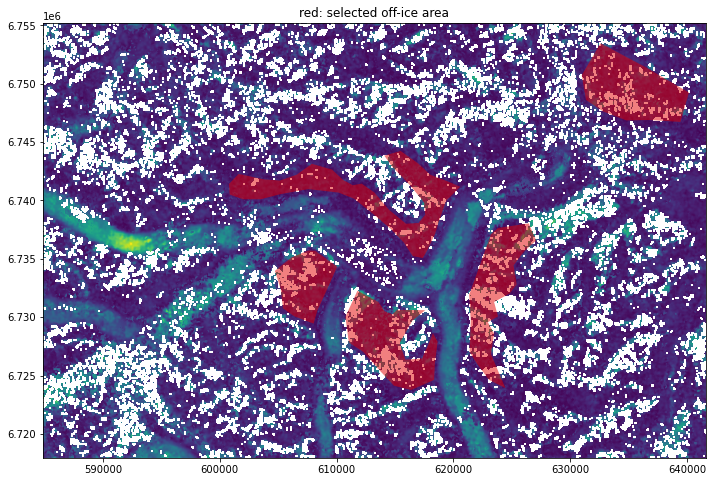

In [8]:
fig, ax0 = plt.subplots(1, 1, figsize=(12, 8))

show(v_src, ax=ax0)
off_ice.plot(ax=ax0, alpha=0.5, facecolor='xkcd:red')
ax0.set_title('red: selected off-ice area');

#### 2. FT results with $V_x$ and $V_y$ (CARST input)

The GFTT module has a fuction called `off_ice_errors` for this metric:

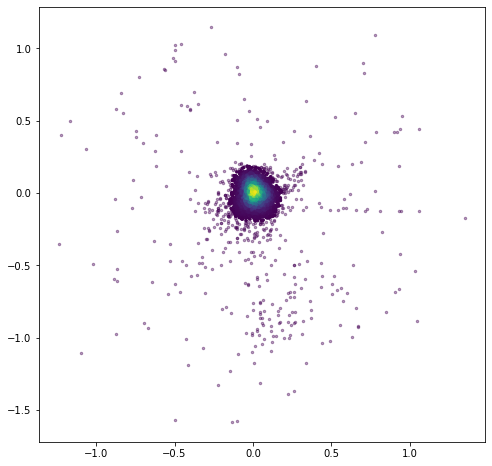

In [9]:
vx, vy, z, thres_idx = gftt.off_ice_errors(vxfile=carst_geotiff_x, vyfile=carst_geotiff_y, off_ice_area=in_shp)

In this case, x-axis is $V_x$ (m/day), y-axis is $V_y$ (m/day), color represents the Gaussian kernel density estimate, and transparent points indicate that those points have a kernel density below a chosen confidence level. The default `thres_sigma` parameter is 3.0, corresponding to a confidence level of 99.7%. 

To estimate whether these errors are randomly distributed, we can see how close this distribution is to the Gaussian distribution. One criterion is to see how much the non-transparent points account for 99.7% of all the points and whether that is close to 99.7%:

In [7]:
np.sum(thres_idx) / vx.shape

array([0.94503564])

This gives us 94.5%, indicating more points falling outside of the chosen confidence interval than assumed. This is okay because the standard deviation of these points would be a conservative estimate, affected by many outliers and larger than the actual standard deviation. 

The standard deviation of $V_x$ and $V_y$ can be thus assigned as the overall uncertainty of both on-ice and off-ice pixels, which serves as a metric for estimating the feature tracking results. 

In [8]:
print('Vx std: {:5f}  m/day'.format(np.std(vx, ddof=1)))
print('Vy std: {:5f}  m/day'.format(np.std(vy, ddof=1)))

Vx std: 0.098629  m/day
Vy std: 0.130734  m/day


Or roughly 1/5 of the pixel size since this is a 32-day pair.

<!-- ![CARST-bedrock](./20180304-20180405_bedrock_vx-vs-vy.png) -->

#### 2.1 Multi images

In [10]:
# CARST files (Vx and Vy)
carst_geotiff_x = '/home/jovyan/Projects/PX_comparison/PX/CARST/20180304_20180405_LS8-061018_chip32_skip1_Gau/20180304-20180405_velo-raw_vx.tif'
carst_geotiff_y = '/home/jovyan/Projects/PX_comparison/PX/CARST/20180304_20180405_LS8-061018_chip32_skip1_Gau/20180304-20180405_velo-raw_vy.tif'

**old code (using all 721549 samples)**

CPU times: user 1h 55min 56s, sys: 890 ms, total: 1h 55min 57s
Wall time: 1h 55min 58s


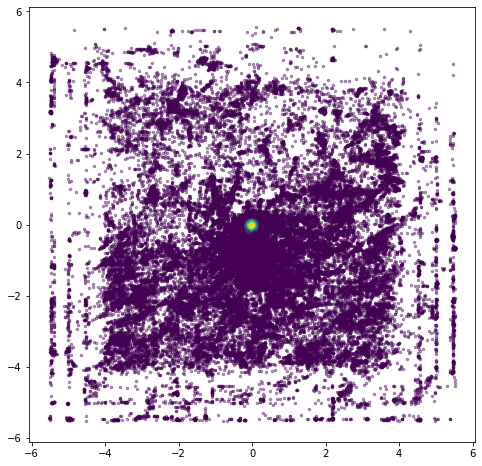

In [11]:
%%time
vx, vy, z, thres_idx = gftt.off_ice_errors(vxfile=carst_geotiff_x, vyfile=carst_geotiff_y, off_ice_area=in_shp)

In [28]:
print(np.sum(thres_idx) / vx.shape)
print('Vx std: {:5f}  m/day'.format(np.std(vx, ddof=1)))
print('Vy std: {:5f}  m/day'.format(np.std(vy, ddof=1)))

[0.90100049]
Vx std: 0.679299  m/day
Vy std: 0.659811  m/day


In [13]:
from scipy.stats import gaussian_kde
xy = np.vstack([vx, vy])

In [23]:
%%time
z = gaussian_kde(xy[:, :20000])(xy[:, :20000])

CPU times: user 5.12 s, sys: 3 µs, total: 5.12 s
Wall time: 5.11 s


In [24]:
%%time
z = gaussian_kde(xy[:, :10000])(xy[:, :10000])

CPU times: user 1.28 s, sys: 159 µs, total: 1.28 s
Wall time: 1.28 s


In [20]:
xy.shape

(2, 721549)

**New code (using 10000 samples)**

CPU times: user 1.56 s, sys: 40 ms, total: 1.6 s
Wall time: 1.63 s


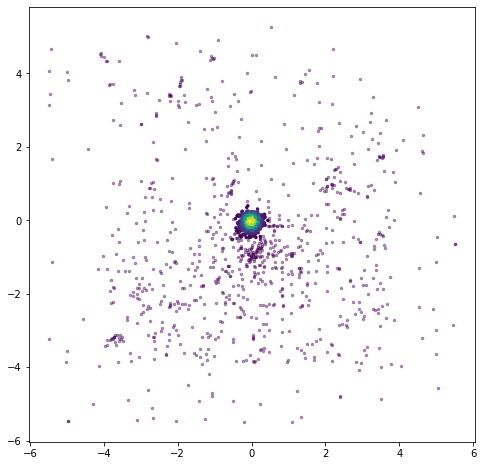

In [30]:
%%time
vx, vy, z, thres_idx = gftt.off_ice_errors(vxfile=carst_geotiff_x, vyfile=carst_geotiff_y, off_ice_area=in_shp, max_n=10000)

In [31]:
print(np.sum(thres_idx) / vx.shape)
print('Vx std: {:5f}  m/day'.format(np.std(vx, ddof=1)))
print('Vy std: {:5f}  m/day'.format(np.std(vy, ddof=1)))

[0.9097]
Vx std: 0.670716  m/day
Vy std: 0.688340  m/day


#### 3. FT results with $V$ (GIV input)

The `off_ice_errors` has a different syntax for the input with only $V$ available. (Note the unit of $V$ here is m/year instead of m/day.)

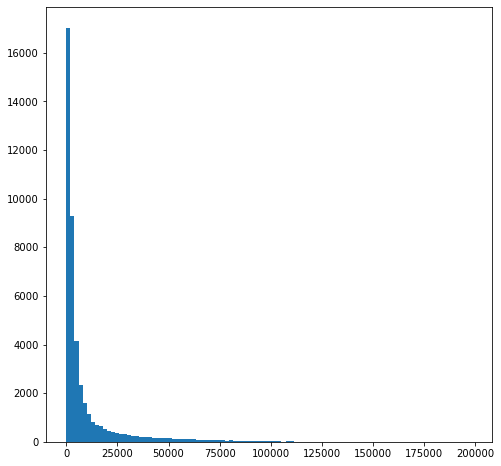

In [9]:
v, bins = gftt.off_ice_errors(vfile=giv_geotiff, off_ice_area=in_shp)

This shows the histogram of velocity $V^2 = V_x^2 + V_y^2$. X-axis is in m$^2$/year$^2$. If we assume 

1. $\overline{V_x} = \overline{V_y} = 0$ (i.e. no biased offset at the off-ice area), and
2. the variance of $V_x$ is the same from the variance of $V_y$ ($\sigma^2 = \sigma_x^2 = \sigma_y^2$),

then theoretically $V^2 / \sigma^2$ follows a Chi-square distribution with a mean value of its degree of freedom, $k = 2$,

$$
\frac{V^2}{\sigma^2} \sim \chi^2(k, 2k).
$$

We can firstly find out $\sigma^2$ from the mean value of $V^2$ divided by the degree of freedom:

$$
\sigma^2 =  \frac{\overline{V^2}}{k}
$$

In [10]:
sigma2 = np.mean(v ** 2) / 2
sigma2   # in m^2/year^2

4688.3508334802345

To test if $V^2 / \sigma^2$ resembles Chi-square, we can calculate the variance of $V^2 / \sigma^2$ divided by the mean value of of $V^2 / \sigma^2$ and see if it is close to 2: 

In [11]:
chi2 = v ** 2 / sigma2

np.var(chi2, ddof=1) / np.mean(chi2)

6.497069177323472

This is a much larger value than 2, which means there are outliers, and $\sigma^2$ is very likely an over-estimate. Again, this is okay as we are conservative about the uncertainty estimate.

Finally, the square root of $\sigma^2$ can be assigned as the overall uncertainty of both on-ice and off-ice pixels (for $V_x$ or $V_y$, not for $V$) and can be directly compared to the results from the previous section. 

In [12]:
print('Vx and Vy std: {:5f}  m/day'.format(np.sqrt(sigma2) / 365.25))

Vx and Vy std: 0.187465  m/day


This gives as a random error on the bedrock of ~0.19 m/day.